In [197]:
import json
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow as tf

from tensorflow.contrib.keras.python.keras.models import Sequential, load_model
from tensorflow.contrib.keras.python.keras.layers import Input, InputLayer, Dense, Conv2D, Dropout, BatchNormalization, GaussianNoise, Flatten, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.contrib.keras.python.keras.optimizers import Adam
from tensorflow.contrib.keras.python.keras.regularizers import l1, l2
from tensorflow.contrib.keras.python.keras.initializers import glorot_normal
from tensorflow.contrib.keras.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.contrib.keras.python.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
%matplotlib inline

In [122]:
tf.__version__

'1.3.1'

In [2]:
TRAIN_FILE = 'data/train.json'
TEST_FILE = 'data/test.json'

In [3]:
def load_data(filename):
    df = pd.read_json(filename)
    images = df.apply(lambda c_row: [np.stack([c_row['band_1'], c_row['band_2']], -1).reshape((75,75,2))], 1)
    images = np.stack(images).squeeze()
    ids = df.id.tolist()
    return ids, images, df.is_iceberg.as_matrix() if 'is_iceberg' in df else None

In [176]:
%%time
_, X_train_all, y_train_all = load_data(TRAIN_FILE)
ids_test, X_test, y_test = load_data(TEST_FILE)

CPU times: user 16 s, sys: 9.99 s, total: 25.9 s
Wall time: 29.2 s


In [177]:
X_train_all.shape, y_train_all.shape, X_test.shape

((1604, 75, 75, 2), (1604,), (8424, 75, 75, 2))

In [180]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_all, y_train_all, random_state=2**8, test_size=0.1)

In [181]:
mean = X_train.mean()
devi = X_train.std()

def normalize(X):
    return (X - mean) / devi

X_train_scaled = normalize(X_train)
X_valid_scaled = normalize(X_valid)
X_test_scaled = normalize(X_test)

In [190]:
INPUT_SHAPE = X_train.shape[1:]

def other_model():
    model = Sequential()

    model.add(BatchNormalization(input_shape=INPUT_SHAPE))
    for i in range(4):
        model.add(Conv2D(8*2**i, kernel_size=(3,3), activation='elu'))
        model.add(MaxPooling2D((2,2)))
    model.add(GlobalMaxPooling2D())
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='elu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='elu'))
    model.add(Dense(1, kernel_initializer=glorot_normal(), activation='sigmoid'))
    return model

def my_model():
    model = Sequential()

    model.add(InputLayer(input_shape=INPUT_SHAPE))
    #model.add(BatchNormalization(input_shape=INPUT_SHAPE))
    #model.add(GaussianNoise(0.1))

    model.add(Conv2D(32, kernel_size=(11, 11), strides=(2, 2), kernel_initializer=glorot_normal(), activation='elu'))
    #model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv2D(32, kernel_size=(11, 11), strides=(2, 2), kernel_initializer=glorot_normal(), activation='elu'))
    #model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(64, kernel_size=(7, 7), kernel_initializer=glorot_normal(), activation='elu'))
    #model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(64, kernel_size=(5, 5), kernel_initializer=glorot_normal(), activation='elu'))
    #model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dropout(0.6))

    model.add(Dense(16, kernel_initializer=glorot_normal(), activation='elu'))
    #model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(1, kernel_initializer=glorot_normal(), activation='sigmoid'))
    return model
    

model = my_model()

model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 75, 75, 2)         0         
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 33, 33, 32)        7776      
_________________________________________________________________
dropout_132 (Dropout)        (None, 33, 33, 32)        0         
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 12, 12, 32)        123936    
_________________________________________________________________
dropout_133 (Dropout)        (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 6, 6, 64)          100416    
_________________________________________________________________
dropout_134 (Dropout)        (None, 6, 6, 64)          0         
__________

In [191]:
#tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1, batch_size=32, write_graph=True, write_grads=True)
checkpoint = ModelCheckpoint('checkpoint_{epoch:03d}_{val_loss:.2f}.hdf5', monitor='val_loss', save_best_only=True)
#earlystopping = EarlyStopping(patience=10, monitor='loss')
plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=15)

In [194]:
%%time
history = model.fit(
    *shuffle(X_train_scaled, y_train),
    validation_data=shuffle(X_valid_scaled, y_valid),
    #batch_size=64,
    epochs=64,
    callbacks=[
        #tensorboard,
        checkpoint,
        plateau
    ]
)

Train on 1443 samples, validate on 161 samples
Epoch 1/64
1443/1443 [==============================] - 0s - loss: 0.1874 - val_loss: 0.2888
Epoch 2/64
1443/1443 [==============================] - 0s - loss: 0.2442 - val_loss: 0.2656
Epoch 3/64
1443/1443 [==============================] - 0s - loss: 0.1847 - val_loss: 0.2423
Epoch 4/64
1443/1443 [==============================] - 0s - loss: 0.1849 - val_loss: 0.2937
Epoch 5/64
1443/1443 [==============================] - 0s - loss: 0.1673 - val_loss: 0.2741
Epoch 6/64
1443/1443 [==============================] - 0s - loss: 0.1418 - val_loss: 0.3107
Epoch 7/64
1443/1443 [==============================] - 0s - loss: 0.1561 - val_loss: 0.3738
Epoch 8/64
1443/1443 [==============================] - 0s - loss: 0.1531 - val_loss: 0.3565
Epoch 9/64
1443/1443 [==============================] - 0s - loss: 0.1358 - val_loss: 0.3262
Epoch 10/64
1443/1443 [==============================] - 0s - loss: 0.1002 - val_loss: 0.2970
Epoch 11/64
1443/1443 

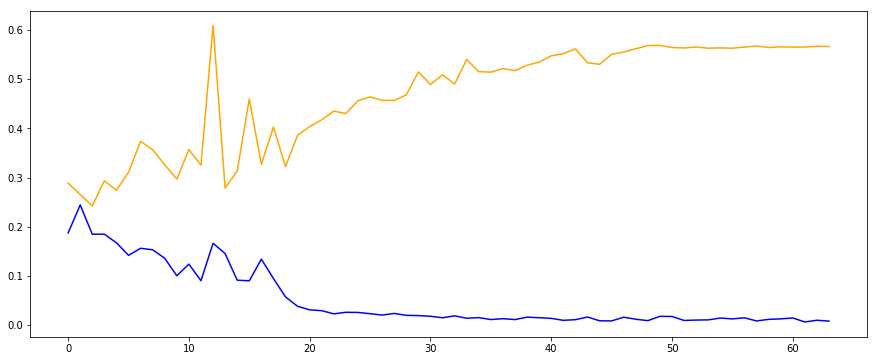

In [195]:
fig, ax = plt.subplots(figsize=(15,6))

plt.plot(history.history['loss'], color='blue')
plt.plot(history.history['val_loss'], color='orange')

In [198]:
model = load_model('checkpoint_025_0.22.hdf5')
#model.save('model_02925.h5')

In [82]:
imgen_train = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=True
)

imgen_valid = ImageDataGenerator()

imgen_train.fit(X_train_scaled)
imgen_valid.fit(X_valid_scaled)

ValueError: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (902, 75, 75, 2) (2 channels).

In [ ]:
%%time
history = model.fit(
    *shuffle(X_train, y_train),
    validation_data=shuffle(X_valid, y_valid),
    batch_size=64,
    epochs=50
)

In [199]:
def predict():
    print('> Predicting test data')
    y_pred = model.predict(X_test_scaled)
    print('> Writing submission file')
    with open('submission.csv', 'w') as f:
        f.write('id,is_iceberg\n')
        for id_, pred in zip(ids_test, y_pred):
            f.write('{},{}\n'.format(id_, pred[0]))

predict()

> Predicting test data
> Writing submission file
